<a href="https://colab.research.google.com/github/vubanc/MovieGenreIdentifier_NaiveBayes/blob/main/MovieGenreIdentifier_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Movie Genre Identifier**

This is an NLP (Natural Language Processing) project. The objective of this project is to build a model that predicts the genre of a movie by taking the movie's description as input. The dataset for this project was produced by merging three different movies datasets collected from Kaggle. Every movie in the dataset has a title, a description and one or more genres. In this notebook, a LSTM (long-short-term memory) model was trained and tested on the dataset to predict the genres of the movies.

**Overview of the Cleaned Dataset**
- Total Movies: 4000
- Total Genres: 5
- Oldest Movie in the dataset is The Cabinet of Dr. Caligari from 1920
- Latest Movie in the dataset is The Gray Man from 2022

**Visual Representation of the Model**
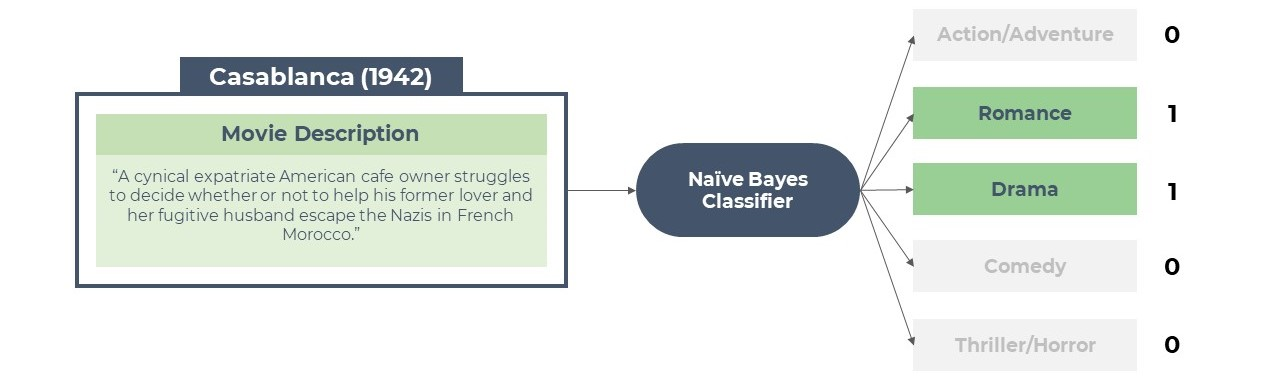

### **Importing Libraries and Datasets**

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import spacy

import random

import torch as torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

In [7]:
df_input = pd.read_csv("/content/drive/MyDrive/Work/Personal Projects/MovieGenreIdentifier_NLP/LSTM Input.csv")

### **Helper Functions**

In [ ]:
#Splitting training, validation, and testing data for action labels only
def data_splitter(features, labels):
  split_frac = 0.8
  train_x = features[0:int(split_frac*len(features))]
  train_y = labels[0:int(split_frac*len(features))]
  remaining_x = features[int(split_frac*len(features)):]
  remaining_y = labels[int(split_frac*len(features)):]
  valid_x = remaining_x[0:int(len(remaining_x)*0.5)]
  valid_y = remaining_y[0:int(len(remaining_y)*0.5)]
  test_x = remaining_x[int(len(remaining_x)*0.5):]
  test_y = remaining_y[int(len(remaining_y)*0.5):]

  return train_x, train_y, valid_x, valid_y, test_x, test_y

In [ ]:
def data_loader(train_x, train_y, valid_x, valid_y, test_x, test_y):
  train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
  valid_data = TensorDataset(torch.from_numpy(valid_x), torch.from_numpy(valid_y))
  test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

  batch_size = 520

  train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
  valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)
  test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

  return train_loader, valid_loader, test_loader

### **LSTM Class**

In [ ]:
class LSTM(nn.Module):

  def __init__(self, vocab_size, embedding_size, hidden_size, output_size, number_of_layers, learning_rate, dropout_prob=0.5):
    super(LSTM,self).__init__()
    self.output_size = output_size
    self.hidden_size = hidden_size
    self.number_of_layers = number_of_layers
    self.embedding = nn.Embedding(vocab_size, embedding_size)
    self.lstm = nn.LSTM(embedding_size, hidden_size, number_of_layers, dropout=dropout_prob, batch_first=True) #Input shape >- (batch_size, sequence_length, number_of_features)
    self.fc = nn.Linear(hidden_size, output_size)
    self.sigmoid = nn.Sigmoid() #1/(1+e^-x)
    self.dropout = nn.Dropout(0.3)

    self.loss = nn.CrossEntropyLoss() #Binary Cross Entropy Loss
    self.optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)

  def init_hidden(self,batch_size):
    weight = next(self.parameters()).data

    hidden = (weight.new(self.number_of_layers, batch_size, self.hidden_size).zero_(),
               weight.new(self.number_of_layers, batch_size, self.hidden_size).zero_())
    return hidden

  def forward(self, hidden, input): #This forward method produces outputs for an entire batch of inputs
    batch_size = input.size(0)

    embedded_input = self.embedding(input) #Converts input from [batch_size, sequence_length] to [batch_size, sequence_length, embedding_size]
    outputs,hn = self.lstm(embedded_input, hidden) #Outputs -> [batch_size, seq_length, hidden_size] hn-> [number_of_layers, batch_size, hidden_size]
    outputs = outputs.contiguous().view(-1,self.hidden_size) #Reshapes to [batch_size*sequence_length, hidden_size]

    outputs = self.dropout(outputs) #Randomly converts some elements to 0 (with prob=0.3) and then multiplies all elements with 1/(1-prob)
    outputs = self.fc(outputs) #Linear transformation on outputs/hidden states from all time steps. Outputs shape [batch_size*seq_length, 1]
    sig_outputs = self.sigmoid(outputs) #Applies 1/(1+e^-x)


    sig_outputs = sig_outputs.view(batch_size, -1) #Reshapes sigmoid outputs into [batch_size, sequence_length] from [batch_size*sequence_length, 1]
    sig_outputs = sig_outputs[:,-1] #Returns the sigmoid outputs of the last time step

    return sig_outputs, hn

  def train(self, train_loader, valid_loader, epochs):

    for epoch in range(epochs):
      for i,(features, labels) in enumerate(train_loader):
        batch_size = features.size(0)
        hidden = self.init_hidden(batch_size)
        outputs, hidden = self.forward(hidden, features)
        loss = self.loss(outputs.squeeze(), labels.float()) #Squeeze converts any tensor into a 1-D tensor

        self.optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(self.parameters(), 5)
        self.optimizer.step()

        if (epoch+1)%epochs==0:
          total_valid_loss = []
          for j,(valid_features, valid_labels) in enumerate(valid_loader):
            batch_size = valid_features.size(0)
            hidden = self.init_hidden(batch_size)
            valid_outputs,_ = self.forward(hidden, valid_features)
            valid_loss = self.loss(valid_outputs.squeeze(), valid_labels.float())
            total_valid_loss.append(valid_loss.item())
          print(f"Final Epoch | step:{i} | training loss: {loss} | validation loss: {np.mean(total_valid_loss)}")
    print("Training Complete!")

  def test(self, test_loader):
    test_losses = []
    all_predictions = []
    correct_predictions = []

    with torch.no_grad():
      for features, labels in test_loader:
        batch_size = features.size(0)
        hidden = self.init_hidden(batch_size)
        outputs, hiddens = self.forward(hidden, features)
        loss = self.loss(outputs.squeeze(), labels.float())
        test_losses.append(loss.item())

        predictions = torch.round(outputs.squeeze()) #Rounding off to nearest integer makes it binary
        all_predictions += predictions.tolist()

        correct = ((predictions==labels).int()).tolist()
        correct_predictions += correct

      print(f"Test loss: {np.mean(test_losses)}")
      print(f"Accuracy: {np.sum(correct_predictions)*100/len(correct_predictions)}%")

## **Training and Testing**

### **Action/Adventure**

In [ ]:
train_x, train_y, valid_x, valid_y, test_x, test_y = data_splitter(features, action_labels)
train_loader, valid_loader, test_loader = data_loader(train_x, train_y, valid_x, valid_y, test_x, test_y)

In [ ]:
model = LSTM(len(vocabulary), 512, 128, 1, 1, 0.005)
model

LSTM(
  (embedding): Embedding(10202, 512)
  (lstm): LSTM(512, 128, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.3, inplace=False)
  (loss): CrossEntropyLoss()
)

In [ ]:
model.train(train_loader, valid_loader, 20)

Final Epoch | step:0 | training loss: 1025.3748779296875 | validation loss: 362.2633972167969
Final Epoch | step:1 | training loss: 995.1278686523438 | validation loss: 361.4346618652344
Final Epoch | step:2 | training loss: 908.568603515625 | validation loss: 361.1018371582031
Final Epoch | step:3 | training loss: 1013.183837890625 | validation loss: 361.062255859375
Final Epoch | step:4 | training loss: 977.9482421875 | validation loss: 360.7985534667969
Training Complete!


In [ ]:
model.test(test_loader)

Test loss: 912.2841186523438
Accuracy: 76.99386503067484%


### **Romance**

In [ ]:
train_x, train_y, valid_x, valid_y, test_x, test_y = data_splitter(features, romance_labels)
train_loader, valid_loader, test_loader = data_loader(train_x, train_y, valid_x, valid_y, test_x, test_y)

In [ ]:
model = LSTM(len(vocabulary), 512, 256, 1, 1, 0.005)
model

LSTM(
  (embedding): Embedding(10202, 512)
  (lstm): LSTM(512, 256, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.3, inplace=False)
  (loss): CrossEntropyLoss()
)

In [ ]:
model.train(train_loader, valid_loader, 20)

Final Epoch | step:0 | training loss: 720.663818359375 | validation loss: 499.2206726074219
Final Epoch | step:1 | training loss: 632.371826171875 | validation loss: 499.95440673828125
Final Epoch | step:2 | training loss: 643.2562255859375 | validation loss: 499.63946533203125
Final Epoch | step:3 | training loss: 702.4036865234375 | validation loss: 499.8611755371094
Final Epoch | step:4 | training loss: 644.6004638671875 | validation loss: 499.5751037597656
Training Complete!


In [ ]:
model.test(test_loader)

Test loss: 391.8970031738281
Accuracy: 75.15337423312883%


### **Drama**

In [ ]:
train_x, train_y, valid_x, valid_y, test_x, test_y = data_splitter(features, drama_labels)
train_loader, valid_loader, test_loader = data_loader(train_x, train_y, valid_x, valid_y, test_x, test_y)

In [ ]:
model = LSTM(len(vocabulary), 512, 128, 1, 1, 0.0005)
model

LSTM(
  (embedding): Embedding(10202, 512)
  (lstm): LSTM(512, 128, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.3, inplace=False)
  (loss): CrossEntropyLoss()
)

In [ ]:
model.train(train_loader, valid_loader, 50)

Final Epoch | step:0 | training loss: 1746.755615234375 | validation loss: 1160.050537109375
Final Epoch | step:1 | training loss: 1765.533203125 | validation loss: 1160.5281982421875
Final Epoch | step:2 | training loss: 1806.6634521484375 | validation loss: 1160.380615234375
Final Epoch | step:3 | training loss: 1703.281005859375 | validation loss: 1160.6114501953125
Final Epoch | step:4 | training loss: 1734.44580078125 | validation loss: 1160.3582763671875
Training Complete!


In [ ]:
model.test(test_loader)

Test loss: 38.132110595703125
Accuracy: 46.625766871165645%


### **Comedy**

In [ ]:
train_x, train_y, valid_x, valid_y, test_x, test_y = data_splitter(features, comedy_labels)
train_loader, valid_loader, test_loader = data_loader(train_x, train_y, valid_x, valid_y, test_x, test_y)

In [ ]:
model = LSTM(len(vocabulary), 512, 256, 1, 1, 0.005)
model

LSTM(
  (embedding): Embedding(10202, 512)
  (lstm): LSTM(512, 256, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.3, inplace=False)
  (loss): CrossEntropyLoss()
)

In [ ]:
model.train(train_loader, valid_loader, 20)

Final Epoch | step:0 | training loss: 1592.2781982421875 | validation loss: 925.8703002929688
Final Epoch | step:1 | training loss: 1411.24560546875 | validation loss: 926.4656982421875
Final Epoch | step:2 | training loss: 1434.6168212890625 | validation loss: 926.7183227539062
Final Epoch | step:3 | training loss: 1398.81884765625 | validation loss: 927.1101684570312
Final Epoch | step:4 | training loss: 1416.3612060546875 | validation loss: 925.8428955078125
Training Complete!


In [ ]:
model.test(test_loader)

Test loss: 672.9620361328125
Accuracy: 70.85889570552148%


### **Thriller/Horror**

In [ ]:
train_x, train_y, valid_x, valid_y, test_x, test_y = data_splitter(features, thriller_labels)
train_loader, valid_loader, test_loader = data_loader(train_x, train_y, valid_x, valid_y, test_x, test_y)

In [ ]:
model = LSTM(len(vocabulary), 512, 256, 1, 1, 0.005)
model

LSTM(
  (embedding): Embedding(10202, 512)
  (lstm): LSTM(512, 256, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.3, inplace=False)
  (loss): CrossEntropyLoss()
)

In [ ]:
model.train(train_loader, valid_loader, 20)

Final Epoch | step:0 | training loss: 935.3851928710938 | validation loss: 488.2383117675781
Final Epoch | step:1 | training loss: 912.0474243164062 | validation loss: 488.7568359375
Final Epoch | step:2 | training loss: 870.7687377929688 | validation loss: 488.72021484375
Final Epoch | step:3 | training loss: 773.878173828125 | validation loss: 488.726318359375
Final Epoch | step:4 | training loss: 779.8798828125 | validation loss: 489.2744140625
Training Complete!


In [ ]:
model.test(test_loader)

Test loss: 345.4905700683594
Accuracy: 69.93865030674847%


## **The End**